# Lab 7: Implementing Object Detection with YOLO for Telecom Infrastructure

**Objective**
This lab focuses on implementing object detection for telecom infrastructure using YOLOv8. Students will learn to train and deploy a YOLO model for detecting different types of antennas (GSM and Microwave) in real-world scenarios. The lab demonstrates practical applications of object detection in the telecommunications industry, covering model training, evaluation, and inference on new images.

**Dataset Information**


Source: https://universe.roboflow.com/object-detection-yolo-c8gsd/tower-detection-tff1p

Classes: 3 types of antennas

- GSM Antenna
- GSM Antenna (variant)
- Microwave Antenna


**Dataset Split**

- Training: 1350 images (99%)
- Validation: 7 images (1%)
- Testing: 5 images

### Tasks Overview


1.   Environment Setup and Dependencies Installation
2.   Dataset Download and Preparation
3.   YOLOv8 Model Configuration
4.   Model Training
5.   Performance Evaluation
6.   Inference on Test Images
7.   Model Export

### Task 1: Environment Setup and Dependencies Installation

In [ ]:
# Install required packages
!pip install ultralytics
!pip install roboflow


In [3]:
# Import necessary libraries
import ultralytics
from ultralytics import YOLO
from roboflow import Roboflow
import os
import cv2
import numpy as np
from google.colab import drive

### Task 2: Dataset Download and Preparation

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set working directory
import os
%cd /content

Mounted at /content/drive
/content


**Setup Data path**

In [4]:
# Define dataset path (update this to your Google Drive path)
DATASET_PATH = r'D:\Nokia_DL_L3_lab\OneDrive_1_28-12-2024\Lab-7\Resource\Tower Detection.v3i.yolov8'  # Update this path

# Verify dataset structure
# !ls {DATASET_PATH}

# Display data.yaml content
# !cat {DATASET_PATH}/data.yaml

# Setup directory structure
train_path = os.path.join(DATASET_PATH, 'train/images')
valid_path = os.path.join(DATASET_PATH, 'valid/images')
test_path = os.path.join(DATASET_PATH, 'test/images')

# Verify image counts
print(f"Training images: {len(os.listdir(train_path))}")
print(f"Validation images: {len(os.listdir(valid_path))}")
print(f"Test images: {len(os.listdir(test_path))}")

Training images: 1350
Validation images: 7
Test images: 6


Data Visualization

Sample Training Images:


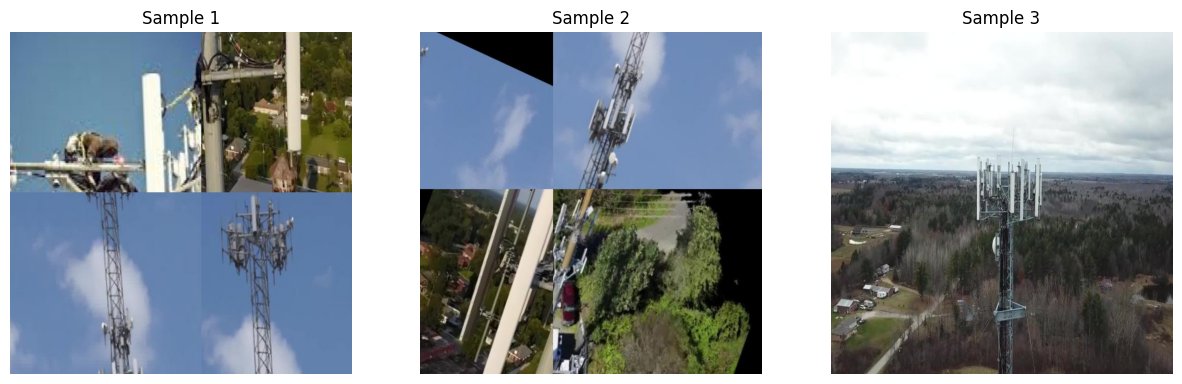

In [5]:
import matplotlib.pyplot as plt
import random

def display_sample_images(image_path, num_samples=3):
    """Display random sample images from the dataset"""
    images = os.listdir(image_path)
    samples = random.sample(images, num_samples)

    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(samples, 1):
        img = cv2.imread(os.path.join(image_path, img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_samples, i)
        plt.imshow(img)
        plt.title(f'Sample {i}')
        plt.axis('off')
    plt.show()

# Display sample training images
print("Sample Training Images:")
display_sample_images(train_path)

### Task 3: YOLOv8 Model Configuration

In [6]:
import torch

# Check CUDA availability
print(f"CUDA is available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Device: {torch.cuda.get_device_name(0)}")
    print(f"Number of CUDA devices: {torch.cuda.device_count()}")
    print(f"CUDA Version: {torch.version.cuda}")

CUDA is available: True
CUDA Device: NVIDIA GeForce RTX 4060 Ti
Number of CUDA devices: 1
CUDA Version: 11.8


In [7]:
# Load a pre-trained YOLOv8 model
model = YOLO('yolov8n.pt')

# Move model to GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"\nUsing device: {device}")

# Display model information
print("\nModel Information:")
print(model.info())

# Display model parameters
print(f"\nTotal Parameters: {sum(p.numel() for p in model.parameters())}")

100%|██████████| 6.25M/6.25M [00:00<00:00, 12.0MB/s]



Using device: cuda

Model Information:
YOLOv8n summary: 225 layers, 3,157,200 parameters, 0 gradients, 8.9 GFLOPs
(225, 3157200, 0, 8.8575488)

Total Parameters: 3157200


### Task 4: Model Training


 Configure Training Parameters

In [8]:
# Define training configuration
train_config = {
    'data': os.path.join(DATASET_PATH, 'data.yaml'),
    'epochs': 50,
    'imgsz': 640,
    'batch': 32,
    'name': 'tower_detection_model',
    'patience': 20,         # Early stopping patience
    'save': True,          # Save best model
    'device': 0 if torch.cuda.is_available() else 'cpu',  # Use GPU if available
    'workers': 8,          # Number of worker threads
    'optimizer': 'Adam',   # Optimizer (SGD, Adam, AdamW)
    'lr0': 0.01,          # Initial learning rate
    'weight_decay': 0.0005,# Weight decay
    'exist_ok': True,      # Overwrite existing experiment
    'pretrained': True,    # Use pretrained backbone
    'amp': True,          # Automatic Mixed Precision
}

# Adjust batch size based on available GPU memory
if torch.cuda.is_available():
    gpu_mem = torch.cuda.get_device_properties(0).total_memory / 1e9  # Memory in GB
    print(f"\nGPU Memory Available: {gpu_mem:.2f} GB")

    # Adjust batch size based on GPU memory
    if gpu_mem < 8:
        train_config['batch'] = 8
    elif gpu_mem < 16:
        train_config['batch'] = 16
    else:
        train_config['batch'] = 32

print("\nTraining Configuration:")
for key, value in train_config.items():
    print(f"{key}: {value}")


GPU Memory Available: 8.59 GB

Training Configuration:
data: D:\Nokia_DL_L3_lab\OneDrive_1_28-12-2024\Lab-7\Resource\Tower Detection.v3i.yolov8\data.yaml
epochs: 50
imgsz: 640
batch: 16
name: tower_detection_model
patience: 20
save: True
device: 0
workers: 8
optimizer: Adam
lr0: 0.01
weight_decay: 0.0005
exist_ok: True
pretrained: True
amp: True


Start Training

In [9]:
# Start training with configured parameters
results = model.train(**train_config)

# Save training results
model.save(os.path.join(DATASET_PATH, 'best.pt'))

Ultralytics 8.3.55  Python-3.10.1 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 8188MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=D:\Nokia_DL_L3_lab\OneDrive_1_28-12-2024\Lab-7\Resource\Tower Detection.v3i.yolov8\data.yaml, epochs=50, time=None, patience=20, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=tower_detection_model, exist_ok=True, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, sa

100%|██████████| 755k/755k [00:00<00:00, 6.02MB/s]

Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 225 layers, 3,011,433 parameters, 3,011,417 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 15.6MB/s]


AMP: checks passed 


train: Scanning D:\Nokia_DL_L3_lab\OneDrive_1_28-12-2024\Lab-7\Resource\Tower Detection.v3i.yolov8\train\labels... 1350 images, 1 backgrounds, 0 corrupt: 100%|██████████| 1350/1350 [00:01<00:00, 748.42it/s]


train: New cache created: D:\Nokia_DL_L3_lab\OneDrive_1_28-12-2024\Lab-7\Resource\Tower Detection.v3i.yolov8\train\labels.cache
WARNING  Box and segment counts should be equal, but got len(segments) = 3201, len(boxes) = 16080. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


val: Scanning D:\Nokia_DL_L3_lab\OneDrive_1_28-12-2024\Lab-7\Resource\Tower Detection.v3i.yolov8\valid\labels... 7 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7/7 [00:00<00:00, 291.60it/s]

val: New cache created: D:\Nokia_DL_L3_lab\OneDrive_1_28-12-2024\Lab-7\Resource\Tower Detection.v3i.yolov8\valid\labels.cache


Plotting labels to runs\detect\tower_detection_model\labels.jpg... 
optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\tower_detection_model
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.94G      2.264      2.371      1.971        101        640: 100%|██████████| 85/85 [00:10<00:00,  7.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.47it/s]

                   all          7         21      0.251      0.225      0.151     0.0303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.66G      2.183      2.109      1.956        186        640: 100%|██████████| 85/85 [00:08<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.86it/s]

                   all          7         21      0.144      0.325      0.188     0.0539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.85G      2.121      2.071       1.97         94        640: 100%|██████████| 85/85 [00:08<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.80it/s]

                   all          7         21      0.708     0.0625     0.0534     0.0315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.67G      2.055      2.019      1.897        112        640: 100%|██████████| 85/85 [00:08<00:00, 10.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.25it/s]

                   all          7         21      0.271      0.244      0.223      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.82G      2.004      1.972      1.841        165        640: 100%|██████████| 85/85 [00:08<00:00, 10.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.68it/s]

                   all          7         21      0.408      0.131      0.159     0.0776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.61G      1.977      1.942      1.846         92        640: 100%|██████████| 85/85 [00:08<00:00, 10.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.64it/s]

                   all          7         21      0.148      0.231      0.222      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.98G      1.924      1.881      1.826         77        640: 100%|██████████| 85/85 [00:08<00:00,  9.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.64it/s]

                   all          7         21       0.62      0.163      0.238     0.0718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.73G      1.939      1.873      1.813         84        640: 100%|██████████| 85/85 [00:08<00:00,  9.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.66it/s]

                   all          7         21      0.424      0.425       0.35      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.46G        1.9      1.854      1.803         86        640: 100%|██████████| 85/85 [00:08<00:00, 10.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.53it/s]

                   all          7         21      0.625      0.388      0.459      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.55G      1.909      1.851      1.821         85        640: 100%|██████████| 85/85 [00:08<00:00,  9.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.68it/s]

                   all          7         21      0.288      0.556      0.374      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.55G      1.894       1.82      1.798         83        640: 100%|██████████| 85/85 [00:08<00:00, 10.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.64it/s]

                   all          7         21      0.569      0.322      0.364      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.48G      1.859      1.824      1.781         55        640: 100%|██████████| 85/85 [00:08<00:00, 10.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.39it/s]

                   all          7         21      0.628      0.273      0.378       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.41G      1.834      1.782      1.744         95        640: 100%|██████████| 85/85 [00:08<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.09it/s]

                   all          7         21      0.344      0.394      0.426      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.65G      1.831      1.764      1.762        139        640: 100%|██████████| 85/85 [00:08<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.81it/s]

                   all          7         21          1      0.317      0.438      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50       2.3G      1.828      1.764      1.748        100        640: 100%|██████████| 85/85 [00:08<00:00,  9.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.64it/s]

                   all          7         21      0.704      0.194      0.305      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50       2.6G      1.845      1.759      1.764         82        640: 100%|██████████| 85/85 [00:08<00:00, 10.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.22it/s]

                   all          7         21      0.566      0.294      0.288      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50       2.4G       1.82      1.715      1.739         96        640: 100%|██████████| 85/85 [00:08<00:00,  9.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.00it/s]

                   all          7         21      0.528      0.294      0.415      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.49G      1.823      1.746       1.75        130        640: 100%|██████████| 85/85 [00:08<00:00, 10.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 21.28it/s]

                   all          7         21       0.29      0.194       0.22      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50       2.5G      1.797      1.723      1.734        159        640: 100%|██████████| 85/85 [00:08<00:00,  9.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 20.83it/s]

                   all          7         21      0.389      0.425      0.344      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50       2.7G      1.798      1.681      1.705        102        640: 100%|██████████| 85/85 [00:08<00:00, 10.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.32it/s]

                   all          7         21      0.668      0.394      0.518      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.55G      1.794      1.713      1.735        112        640: 100%|██████████| 85/85 [00:08<00:00, 10.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.91it/s]

                   all          7         21      0.695      0.425      0.602      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.41G      1.764      1.646      1.697         93        640: 100%|██████████| 85/85 [00:08<00:00, 10.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.24it/s]

                   all          7         21      0.591      0.494      0.599      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.66G      1.773      1.663      1.716        101        640: 100%|██████████| 85/85 [00:08<00:00, 10.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 27.03it/s]

                   all          7         21      0.755      0.456      0.533      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.49G       1.78      1.671      1.708         36        640: 100%|██████████| 85/85 [00:08<00:00,  9.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.64it/s]

                   all          7         21      0.702      0.434       0.54      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.81G      1.774      1.654      1.697        105        640: 100%|██████████| 85/85 [00:08<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.32it/s]

                   all          7         21      0.343      0.629      0.392      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50       2.8G      1.755      1.649      1.683        125        640: 100%|██████████| 85/85 [00:08<00:00, 10.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.09it/s]

                   all          7         21      0.446      0.456      0.521       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.83G      1.732      1.606      1.681        100        640: 100%|██████████| 85/85 [00:08<00:00,  9.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.65it/s]

                   all          7         21          1      0.311      0.428      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.75G      1.729      1.589      1.664        122        640: 100%|██████████| 85/85 [00:08<00:00,  9.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 28.57it/s]

                   all          7         21      0.501      0.425      0.402      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.07G      1.741      1.598      1.674        141        640: 100%|██████████| 85/85 [00:08<00:00,  9.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.64it/s]

                   all          7         21      0.869      0.224      0.323      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.73G      1.727      1.598      1.672        173        640: 100%|██████████| 85/85 [00:08<00:00, 10.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.68it/s]

                   all          7         21      0.677      0.486      0.504      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.69G      1.727      1.602       1.67        134        640: 100%|██████████| 85/85 [00:08<00:00, 10.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.81it/s]

                   all          7         21      0.649      0.431      0.575      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.67G      1.724       1.58      1.661         95        640: 100%|██████████| 85/85 [00:08<00:00,  9.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.25it/s]

                   all          7         21       0.68      0.525      0.617      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.75G      1.713      1.586      1.662        104        640: 100%|██████████| 85/85 [00:08<00:00, 10.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.00it/s]

                   all          7         21      0.871      0.425      0.519      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.78G      1.696      1.567      1.651        130        640: 100%|██████████| 85/85 [00:08<00:00, 10.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 19.41it/s]

                   all          7         21      0.594      0.629      0.587      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.54G      1.707      1.568      1.648        111        640: 100%|██████████| 85/85 [00:08<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.00it/s]

                   all          7         21      0.832      0.456      0.632      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.61G      1.707      1.553      1.653         54        640: 100%|██████████| 85/85 [00:08<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 20.83it/s]

                   all          7         21      0.574      0.375      0.348      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.49G      1.683      1.531      1.627         92        640: 100%|██████████| 85/85 [00:08<00:00, 10.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.39it/s]

                   all          7         21      0.767      0.494      0.656      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.89G      1.676      1.509      1.634        115        640: 100%|██████████| 85/85 [00:08<00:00, 10.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.97it/s]

                   all          7         21      0.874      0.541       0.68      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.47G      1.673      1.526      1.635        182        640: 100%|██████████| 85/85 [00:08<00:00, 10.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.64it/s]

                   all          7         21        0.8      0.394      0.522      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.49G      1.662      1.499      1.618         79        640: 100%|██████████| 85/85 [00:08<00:00,  9.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.81it/s]

                   all          7         21          1      0.508      0.669      0.311


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.22G      1.708      1.499      1.681         63        640: 100%|██████████| 85/85 [00:08<00:00, 10.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.10it/s]

                   all          7         21      0.705      0.521      0.598      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.13G      1.685      1.454      1.663         67        640: 100%|██████████| 85/85 [00:08<00:00, 10.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.66it/s]

                   all          7         21      0.761      0.472      0.627      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.14G      1.671      1.443       1.66         58        640: 100%|██████████| 85/85 [00:08<00:00, 10.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.47it/s]

                   all          7         21      0.881      0.479       0.69      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.13G      1.654      1.423      1.649         62        640: 100%|██████████| 85/85 [00:08<00:00, 10.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 28.57it/s]

                   all          7         21      0.723      0.642      0.695      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.12G      1.651      1.416       1.64         58        640: 100%|██████████| 85/85 [00:08<00:00, 10.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.31it/s]

                   all          7         21      0.896      0.597      0.742      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.13G       1.63       1.39      1.629         70        640: 100%|██████████| 85/85 [00:08<00:00, 10.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 27.78it/s]

                   all          7         21      0.981       0.62      0.759      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.15G      1.616      1.381      1.625         59        640: 100%|██████████| 85/85 [00:08<00:00, 10.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 21.26it/s]

                   all          7         21      0.773      0.656      0.735      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.14G      1.615      1.374      1.626         51        640: 100%|██████████| 85/85 [00:08<00:00, 10.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.97it/s]

                   all          7         21      0.649      0.594      0.659      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.15G      1.604      1.357      1.617         80        640: 100%|██████████| 85/85 [00:08<00:00, 10.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.97it/s]

                   all          7         21       0.69      0.656      0.722      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.13G      1.585      1.345      1.602         86        640: 100%|██████████| 85/85 [00:08<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.64it/s]

                   all          7         21      0.742      0.625      0.712      0.315



50 epochs completed in 0.128 hours.
Optimizer stripped from runs\detect\tower_detection_model\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\tower_detection_model\weights\best.pt, 6.2MB

Validating runs\detect\tower_detection_model\weights\best.pt...
Ultralytics 8.3.55  Python-3.10.1 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 8188MiB)
Model summary (fused): 168 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.96it/s]


                   all          7         21      0.894      0.597      0.742      0.369
           GSM Antenna          6         16      0.788       0.25      0.488      0.201
     Microwave Antenna          4          5          1      0.944      0.995      0.536
Speed: 0.3ms preprocess, 1.3ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs\detect\tower_detection_model


### Task 5: Performance Evaluation

In [11]:
# Plot training metrics
from ultralytics.utils.plotting import plot_results



# Plot the results using the static method
plot_results(file=r'D:\Nokia_DL_L3_lab\OneDrive_1_28-12-2024\Lab-7\runs\detect\tower_detection_model\results.png')  # plot results.txt as results.png
plt.show()

# Display final metrics
print("\nTraining Results:")

# Load and display metrics from results.csv
import pandas as pd
try:
    results_df = pd.read_csv(r'D:\Nokia_DL_L3_lab\OneDrive_1_28-12-2024\Lab-7\runs\detect\tower_detection_model\results.csv')
    print("\nFinal Metrics:")
    print(f"Best mAP50: {results_df['metrics/mAP50(B)'].max():.4f}")
    print(f"Best mAP50-95: {results_df['metrics/mAP50-95(B)'].max():.4f}")
    print(f"Final Epoch: {len(results_df)}")
except Exception as e:
    print(f"Could not load results.csv: {e}")



Training Results:

Final Metrics:
Best mAP50: 0.7587
Best mAP50-95: 0.3689
Final Epoch: 50


 Performance Evaluation

In [12]:
# Validate the model
metrics = model.val()

# Display metrics
print(f"mAP50: {metrics.box.map50}")
print(f"mAP50-95: {metrics.box.map}")

Ultralytics 8.3.55  Python-3.10.1 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 8188MiB)
Model summary (fused): 168 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning D:\Nokia_DL_L3_lab\OneDrive_1_28-12-2024\Lab-7\Resource\Tower Detection.v3i.yolov8\valid\labels.cache... 7 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7/7 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.68s/it]


                   all          7         21      0.895      0.597      0.743      0.369
           GSM Antenna          6         16       0.79       0.25      0.491      0.201
     Microwave Antenna          4          5          1      0.944      0.995      0.536
Speed: 6.6ms preprocess, 39.1ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs\detect\tower_detection_model
mAP50: 0.7428534542185669
mAP50-95: 0.3687104210623525


### Task 6: Inference on Test Images

In [13]:
def predict_image(image_path):
    # Perform prediction
    results = model.predict(image_path, conf=0.25)

    # Process and display results
    for result in results:
        boxes = result.boxes
        for box in boxes:
            # Get coordinates and class
            x1, y1, x2, y2 = box.xyxy[0]
            cls = box.cls
            conf = box.conf

            # print(f"Detected {model.names[int(cls)]} with confidence {conf:.2f}")

    return results[0].plot()

# Test on sample image
test_image = r"D:\Nokia_DL_L3_lab\OneDrive_1_28-12-2024\Lab-7\Resource\Tower Detection.v3i.yolov8\test\images\Tower_images_3_jpg.rf.b92f9fd2131aa400640e86c85ea86284.jpg"
prediction = predict_image(test_image)


image 1/1 D:\Nokia_DL_L3_lab\OneDrive_1_28-12-2024\Lab-7\Resource\Tower Detection.v3i.yolov8\test\images\Tower_images_3_jpg.rf.b92f9fd2131aa400640e86c85ea86284.jpg: 640x640 5 GSM Antennas, 1 Microwave Antenna, 17.0ms
Speed: 4.0ms preprocess, 17.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


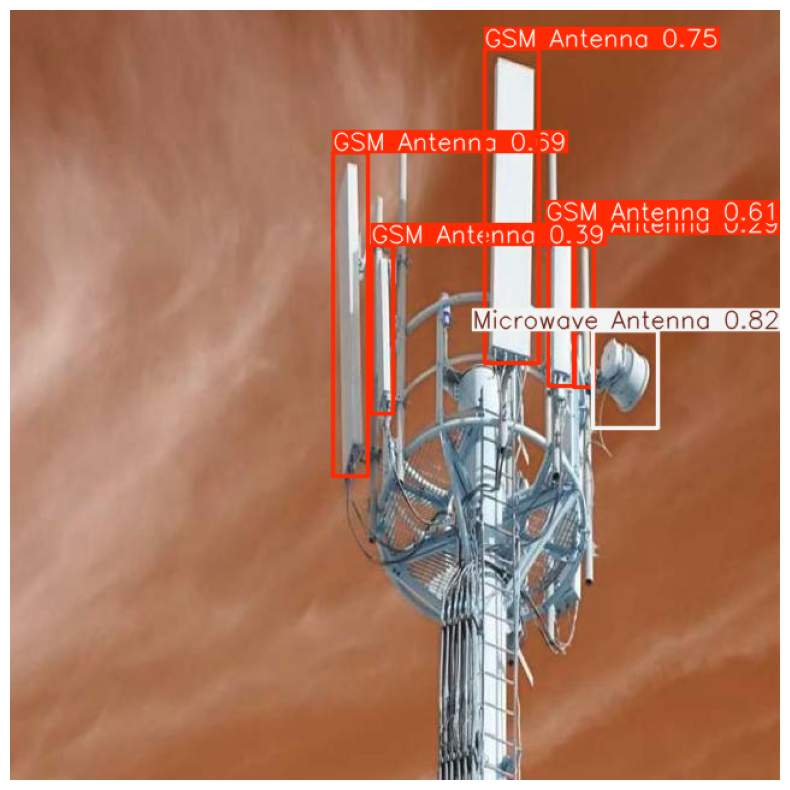

In [14]:
#Plot the show image of prediction
plt.figure(figsize=(10, 10))
plt.imshow(prediction)
plt.axis('off')
plt.show()


### Task 7: Model Export

In [ ]:
# Export model to ONNX format
model.export(format='onnx')